<a href="https://colab.research.google.com/github/ramnarayan-code/llm_reflection/blob/main/langgraph_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the required packages

In [109]:
%%capture --no-stderr
%pip install -U langchain langgraph langchain_openai langchain_experimental langsmith pandas pygraphviz


In [110]:
# Ref: https://medium.com/@anuragmishra_27746/future-of-coding-multi-agent-llm-framework-using-langgraph-092da9493663

# Import packages and define LLM

In [112]:
import os
import operator
from typing import Annotated, Any, Dict, Optional, Sequence, TypedDict, List, Tuple

from langchain_core.pydantic_v1 import BaseModel
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.messages import HumanMessage
from langchain.chains.openai_functions import create_structured_output_runnable
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph

import os
os.environ['OPENAI_API_KEY'] = '<OPENAI-API-KEY>'

llm=ChatOpenAI()

# Definition of Product Owner Agent


In [113]:
class ProductOwner(BaseModel):
    user_stories: str = Field(
        description="PO defined user stories"
    )

product_owner_prompt = ChatPromptTemplate.from_template(
    '''
    **Role**: You are a product owner. You need to create user stories
**Task**: As a product owner, you are required to create 5 user stories based on the use case

**Instructions**:
1. **Understand and Clarify**: Make sure you understand the use case
2. **Define user story and assign priority**: define user story in the below format following the agile standards
*FORMAT*
User story:

*USE CASE*
{use_case}

'''
)
product_owner_agent = create_structured_output_runnable(
    ProductOwner, llm, product_owner_prompt
)


# Definition of Developer Agent


In [114]:
class Developer(BaseModel):
    dev_team_proposal: str = Field(
        description="Developer proposal for the use case implementation"
    )

developer_prompt = ChatPromptTemplate.from_template(
    '''
    **Role**: You are a developer. You need to assess the user stories
**Task**: As a developer, you need to assess the user stories and provide the technical proposal

**Instructions**:
1. **Understand and Clarify**: Make sure you understand the use case and its related user stories
2. **Design the system**: Design a system in the below output format for the use case defining the architecture pattern, defining the components, define the potential technology stack and estimate the efforts
*FORMAT*
Architecture pattern:
Components:
Tech Stack:
ETA:


*USE CASE*
{use_case}

*USE STORIES*
{po_defined_user_stories}
'''
)
developer_agent = create_structured_output_runnable(
    Developer, llm, developer_prompt
)


# Langgraph based collaboration between Product owner and Developer agents

In [115]:
class AgentState(TypedDict):
    use_case: str
    po_defined_user_stories: str
    dev_team_proposal: str

In [116]:
def product_owner(state):
    print(f'Product Owner agent:')
    use_case = state['use_case']
    po_response = product_owner_agent.invoke({'use_case':use_case})
    return {'po_defined_user_stories':po_response.user_stories}

def developer(state):
    print(f'Developer agent:')
    po_defined_user_stories = state['po_defined_user_stories']
    use_case = state['use_case']
    developer_response = developer_agent.invoke({'po_defined_user_stories':po_defined_user_stories, 'use_case':use_case})
    return {'dev_team_proposal':developer_response.dev_team_proposal}

In [117]:
workflow = StateGraph(AgentState)

# Define the nodes
workflow.add_node("product_owner", product_owner)
workflow.add_node("developer", developer)

# Build graph
workflow.set_entry_point("product_owner")
workflow.add_edge("product_owner", "developer")
workflow.add_edge("developer", END)

app = workflow.compile()


# Langgraph Structure:

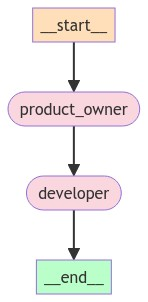

In [123]:

from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

# Interaction with the agents

In [122]:
for stream_msg in app.stream(
    {"use_case": [HumanMessage(content="Design a CRM system using AI")]},
    {"recursion_limit": 100},
):
    if "__end__" not in stream_msg:
        if "product_owner" in stream_msg:
          po_defined_user_stories = stream_msg["product_owner"]["po_defined_user_stories"]
          print(po_defined_user_stories)
        elif "developer" in stream_msg:
          dev_team_proposal = stream_msg["developer"]["dev_team_proposal"]
          print(dev_team_proposal)
        print("----")

Product Owner agent:
User story 1: As a sales manager, I want the CRM system to automatically analyze customer data to provide insights for targeted marketing campaigns.
User story 2: As a customer service representative, I want the CRM system to suggest personalized responses based on historical interactions with customers.
User story 3: As a marketing analyst, I want the CRM system to predict customer behavior using AI algorithms to optimize marketing strategies.
User story 4: As a system administrator, I want the CRM system to automate repetitive tasks such as data entry and lead scoring to improve efficiency.
User story 5: As a business owner, I want the CRM system to generate AI-powered reports that help in making data-driven decisions for business growth.
----
Developer agent:
**Technical Proposal for CRM System using AI**

**Architecture pattern:**
- The proposed architecture pattern for the CRM system is a combination of microservices and serverless computing. This architecture